## Tutorial 1 - Autoencoder

In this example, we will use an autoencoder to 'learn' to recreate hand written digits. Then, we will use the autoencoder to generate new digits to see how well it performs. Finally, we will use the autoencoder to generate a new symbol that is not in the training se (and see that it does a poor job at doing this).

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
import tensorflow as tf
from tensorflow.keras.preprocessing import image


2023-06-19 15:50:52.963435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load and normalize our data

In [2]:
# load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(test_images.shape)

# Flatten the images for a autoencoder input (28x28 is 784 -- therfore, input is 784 neurons)
train_images = np.reshape(train_images, (-1, 784))
test_images = np.reshape(test_images, (-1, 784))
print(train_images.shape)
print(test_images.shape)

# Normalize data - since it's grayscale, we can divide by 255 to get each pixel between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


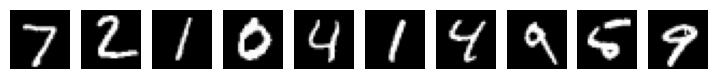

In [3]:
n = 10
plt.figure(figsize=(9, 2))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.imshow(test_images[i].reshape(28, 28), cmap="gray")
  ax.axis('off')

plt.show()

### Create an autoencoder model.

In [4]:
input_dim = 28*28
latent_vec_len = 16 # this is the 'bottleneck' of the autoencoder

# Define the autoencoder architecture
# build the encoder
autoencoder = Sequential()
autoencoder.add(Input(shape=(input_dim,)))
autoencoder.add(Dense(500, activation='relu'))
autoencoder.add(Dense(300, activation='relu'))
autoencoder.add(Dense(100, activation='relu'))

# the bottleneck layer
autoencoder.add(Dense(latent_vec_len, activation='relu'))

# the decoder layer
autoencoder.add(Dense(100, activation='relu'))
autoencoder.add(Dense(300, activation='relu'))
autoencoder.add(Dense(500, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

# Compile the autoencoder model
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

# Get summary
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               392500    
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                                 
 dense_2 (Dense)             (None, 100)               30100     
                                                                 
 dense_3 (Dense)             (None, 16)                1616      
                                                                 
 dense_4 (Dense)             (None, 100)               1700      
                                                                 
 dense_5 (Dense)             (None, 300)               30300     
                                                                 
 dense_6 (Dense)             (None, 500)               1

2023-06-19 15:50:55.970042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train the autoencoder model.

In [5]:
# Train the autoencoder with MNIST data

# NOTE: This is our first example of using callbacks. Callbacks are functions that can be applied during training. In this case,
# we are using EarlyStopping, which will stop training if there is no improvement in the loss after a certain number of epochs.

early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1) # if there is no improvement in 3 epochs, stop training

history = autoencoder.fit(
    x=train_images, # For autoencoders, both the input and the target are the same
    y=train_images, 
    epochs=10, 
    batch_size=128,
    shuffle=True, 
    validation_data=(test_images, test_images),
    callbacks=[early_stop] # this is the callback; notice it's in a list. You can have multiple callbacks.
)

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1970 - val_loss: 0.1392
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1306 - val_loss: 0.1224
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1190 - val_loss: 0.1147
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1134 - val_loss: 0.1106
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1095 - val_loss: 0.1071
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1063 - val_loss: 0.1046
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1038 - val_loss: 0.1031
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1020 - val_loss: 0.1016
Epoch 9/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1006 - val_loss: 0.1007
Epoch 10/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0995 - val_loss: 0.099

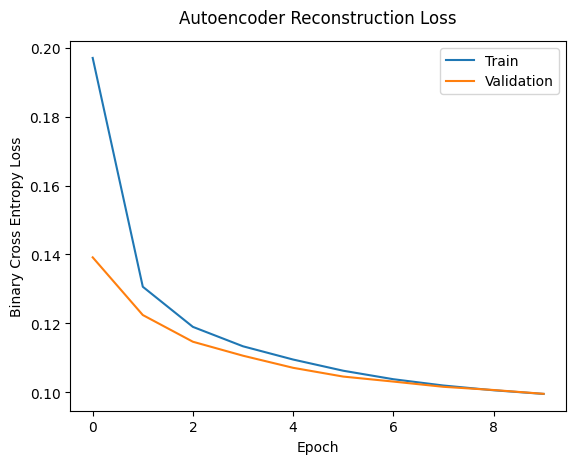

In [6]:
# Plot training and validation loss scores
# against the number of epochs.
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('Epoch')
plt.title('Autoencoder Reconstruction Loss', pad=13)
plt.legend(loc='upper right')

### Test the autoencoder model by reconstructing the test images and visually inspecting the results.

313/313 [==============================] - 1s 2ms/step


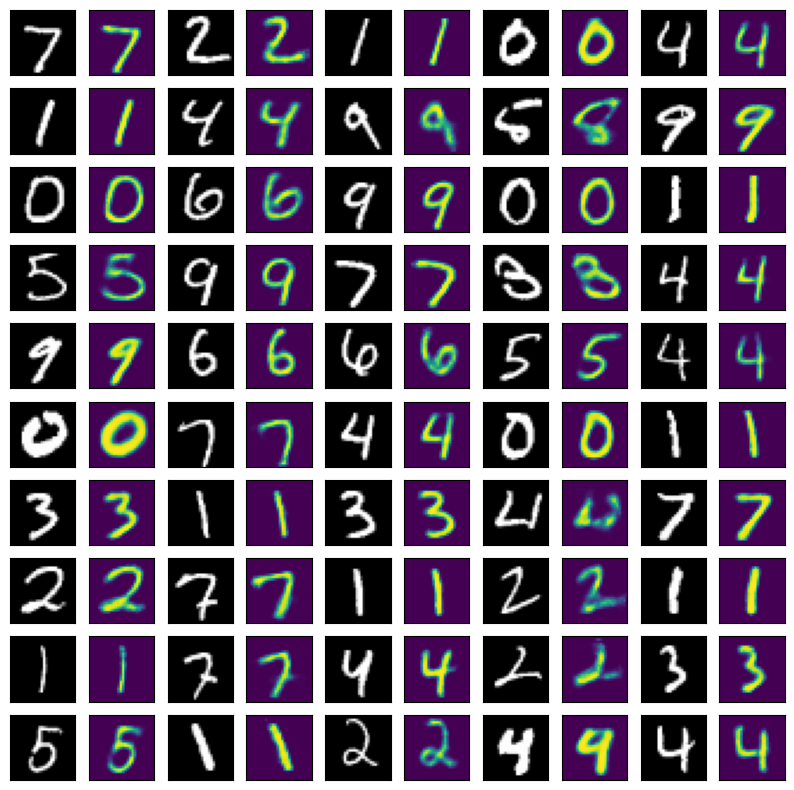

In [7]:
reconstructed_images = autoencoder.predict(test_images)

images = []
for i in range(100):
    images.append(test_images[i].reshape(28,28))
    images.append(reconstructed_images[i].reshape(28,28))
rows = 10
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if (i%2 == 0):
        plt.imshow(images[i],cmap='gray')
    else:
        plt.imshow(images[i])
plt.show()

### Save the autoencoder for later user.

In [8]:
autoencoder.save('initially_trained_autoencoder.tf', save_format='tf')

INFO:tensorflow:Assets written to: initially_trained_autoencoder.tf/assets


INFO:tensorflow:Assets written to: initially_trained_autoencoder.tf/assets


But what happens if we sent it something it has been trained on? Let’s try it out:

1/1 [==============================] - 0s 11ms/step
(1, 784)


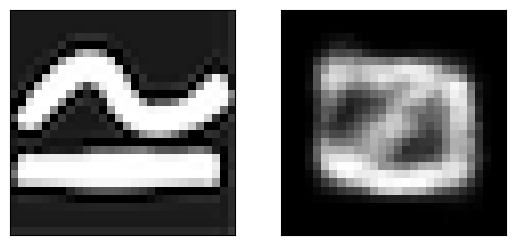

In [9]:
####################################
# load a sample image
image = tf.keras.utils.load_img('testimg02.png', target_size=(28, 28), color_mode = "grayscale")

####################################
# predict an image from this sample
input_arr = tf.keras.utils.img_to_array(image)
input_arr = input_arr/ 255 # normalize between 0 and 1
input_arr = input_arr.reshape(784)
input_arr = np.array([input_arr])  # Convert single image to a batch with one image in it

predictions = autoencoder.predict(input_arr)
print(predictions.shape)

#####################################
# display the two images side by side
# 
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image, cmap="gray")


plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(predictions[0].reshape(28,28), cmap="gray")


plt.show()


### Summary

Since the new image wasn't part of the original training dataset, it's seen as an 'anomoly' by the autoencoder. This is indicated by the difference (error) betweem the original image and the reconstructed image.